In [1]:
import sys
sys.path.append('../')
from quantization.posttraining.layer_scale_optimization import *
from collections import namedtuple
from tqdm import tqdm
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from quantization.methods.clipped_uniform import L2NormQuantization, L3NormQuantization, AciqLaplaceQuantization

In [3]:
torch.max(torch.tensor([0]), torch.tensor([1]))

tensor([1])

In [2]:
args_dict = {'arch': 'resnet18', 'custom_resnet': True, 'pretrained': True, 'dataset': 'imagenet', 'gpu_ids': [0], 'datapath': None,
                     'batch_size': 512, 'shuffle': True, 'workers': 25, 'print_freq': 10,
                     'cal_batch_size': 512, 'cal_set_size': 512}
args_dict['bit_act'] = None
args_dict['bit_weights'] = 3
args_dict['pre_relu'] = False
args_dict['qtype'] = 'max_static'
args = argparse.Namespace()
for k in args_dict:
    setattr(args, k, args_dict[k])
args

Namespace(arch='resnet18', batch_size=512, bit_act=None, bit_weights=3, cal_batch_size=512, cal_set_size=512, custom_resnet=True, datapath=None, dataset='imagenet', gpu_ids=[0], pre_relu=False, pretrained=True, print_freq=10, qtype='max_static', shuffle=True, workers=25)

In [4]:
if 'inf_model' in globals():
    del inf_model

# create model
# Always enable shuffling to avoid issues where we get bad results due to weak statistics
inf_model = CnnModel(args.arch, args.custom_resnet, args.pretrained, args.dataset, args.gpu_ids, args.datapath,
                     batch_size=args.batch_size, shuffle=True, workers=args.workers, print_freq=args.print_freq,
                     cal_batch_size=args.cal_batch_size, cal_set_size=args.cal_set_size)

all_layers = []
if args.bit_weights is not None:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.Conv2d)]
if args.bit_act is not None:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.ReLU)]
if args.bit_act is not None and 'mobilenet' in args.arch:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.ReLU6)]
    
if 'mq' in globals():
    del mq

layers = [all_layers[1], all_layers[2]]
replacement_factory = {nn.ReLU: ActivationModuleWrapperPost,
                       nn.ReLU6: ActivationModuleWrapperPost,
                       nn.Conv2d: ParameterModuleWrapperPost}
mq = ModelQuantizer(inf_model.model, args, layers, replacement_factory)

ParameterModuleWrapperPost - layer1.0.conv1 | MaxAbsStaticQuantization - [alpha: 0.7993, bits: 3, symmetric: True, tails: False, ] | cuda:0
ParameterModuleWrapperPost - layer1.0.conv2 | MaxAbsStaticQuantization - [alpha: 0.4879, bits: 3, symmetric: True, tails: False, ] | cuda:0


In [5]:
n = 41
x = np.linspace(0.01, mq.get_qwrappers()[0].weight_quantization.alpha.item(), n)
y = np.linspace(0.01, mq.get_qwrappers()[1].weight_quantization.alpha.item(), n)
X, Y = np.meshgrid(x, y)
Z = np.empty((n, n))
for i, x_ in enumerate(tqdm(x)):
    for j, y_ in enumerate(y):
        # set clip value to qwrappers
        scales = np.array([X[i, j], Y[i, j]])
        set_clipping(mq, scales, inf_model.device)

        # evaluate with clipping
        loss = inf_model.evaluate_calibration()
        Z[i][j] = loss.item()

100%|██████████| 41/41 [06:27<00:00,  9.45s/it]


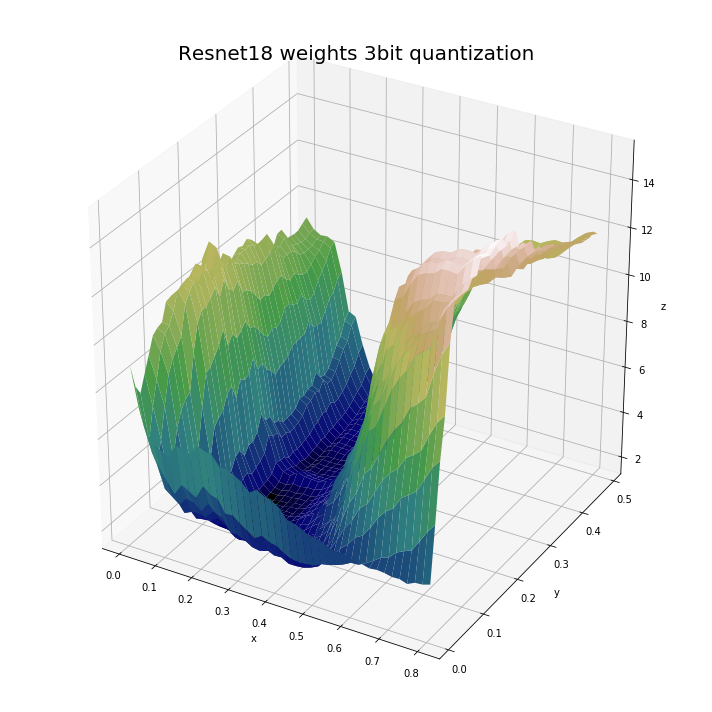

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 100, cmap=cm.CMRmap)
ax.plot_surface(X, Y, Z, cmap=cm.gist_earth)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.set_title('Resnet18 weights 3bit quantization', size=20)
plt.tight_layout()

(array([0.1660376 , 0.12212815]), 1.822968602180481)
(array([0.27154553, 0.169586  ]), 1.7501510381698608)
(array([0.12304047, 0.12450004]), 2.658665657043457)


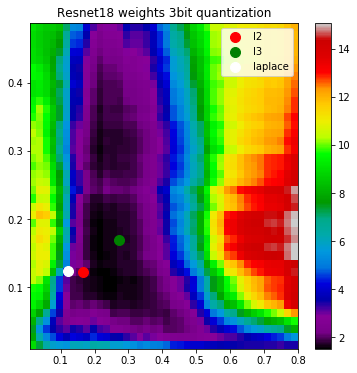

In [13]:
quantizations = [L2NormQuantization, L3NormQuantization, AciqLaplaceQuantization]

init_points = []
for quant in quantizations:
    q0 = quant(nn.Module(), mq.get_qwrappers()[0].weight, 3, symmetric=True, uint=True)
    q1 = quant(nn.Module(), mq.get_qwrappers()[1].weight, 3, symmetric=True, uint=True)
    
    scales = np.array([q0.alpha.item(), q1.alpha.item()])
    set_clipping(mq, scales, inf_model.device)

    # evaluate with clipping
    loss = inf_model.evaluate_calibration()
    init_points.append((scales, loss.item()))

for p in init_points:
    print(p)

def plot_p(ax, init_points, i, c='r'):
    ax.scatter([s[0] for s, l in init_points][i], [s[1] for s, l in init_points][i], color=c, s=100);

from pylab import rcParams
rcParams['figure.figsize'] = 6, 6

x = X
y = Y
z = Z

cmesh = ax.pcolormesh(x, y, z, cmap='RdBu')

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap=cm.spectral)
ax.set_title('Resnet18 weights 3bit quantization')
# set the limits of the plot to the limits of the data
fig.colorbar(c, ax=ax)

plot_p(ax, init_points, 0, 'r')
plot_p(ax, init_points, 1, 'g')
plot_p(ax, init_points, 2, 'w')

plt.legend(['l2', 'l3', 'laplace'])

plt.show()

In [54]:
if 'inf_model' in globals():
    del inf_model

# create model
# Always enable shuffling to avoid issues where we get bad results due to weak statistics
inf_model = CnnModel(args.arch, args.custom_resnet, args.pretrained, args.dataset, args.gpu_ids, args.datapath,
                     batch_size=args.batch_size, shuffle=True, workers=args.workers, print_freq=args.print_freq,
                     cal_batch_size=args.cal_batch_size, cal_set_size=args.cal_set_size)

all_layers = []
if args.bit_weights is not None:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.Conv2d)]
if args.bit_act is not None:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.ReLU)]
if args.bit_act is not None and 'mobilenet' in args.arch:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.ReLU6)]
    
if 'mq' in globals():
    del mq

layers = [all_layers[1], all_layers[2]]
replacement_factory = {nn.ReLU: ActivationModuleWrapperPost,
                       nn.ReLU6: ActivationModuleWrapperPost,
                       nn.Conv2d: ParameterModuleWrapperPost}
mq = ModelQuantizer(inf_model.model, args, layers, replacement_factory)

ParameterModuleWrapperPost - layer1.0.conv1 | MaxAbsStaticQuantization - [alpha: 0.7993, bits: 3, symmetric: True, tails: False, ] | cuda:0
ParameterModuleWrapperPost - layer1.0.conv2 | MaxAbsStaticQuantization - [alpha: 0.4879, bits: 3, symmetric: True, tails: False, ] | cuda:0


In [55]:
n = 41
x = np.linspace(0.01, mq.get_qwrappers()[0].weight_quantization.alpha.item(), n)
y = np.linspace(0.01, mq.get_qwrappers()[1].weight_quantization.alpha.item(), n)
X, Y = np.meshgrid(x, y)
Z = np.empty((n, n))
for i, x_ in enumerate(tqdm(x)):
    for j, y_ in enumerate(y):
        # set clip value to qwrappers
        scales = np.array([X[i, j], Y[i, j]])
        set_clipping(mq, scales, inf_model.device)

        # evaluate with clipping
        loss = inf_model.evaluate_calibration()
        Z[i][j] = loss.item()

100%|██████████| 41/41 [06:23<00:00,  9.35s/it]


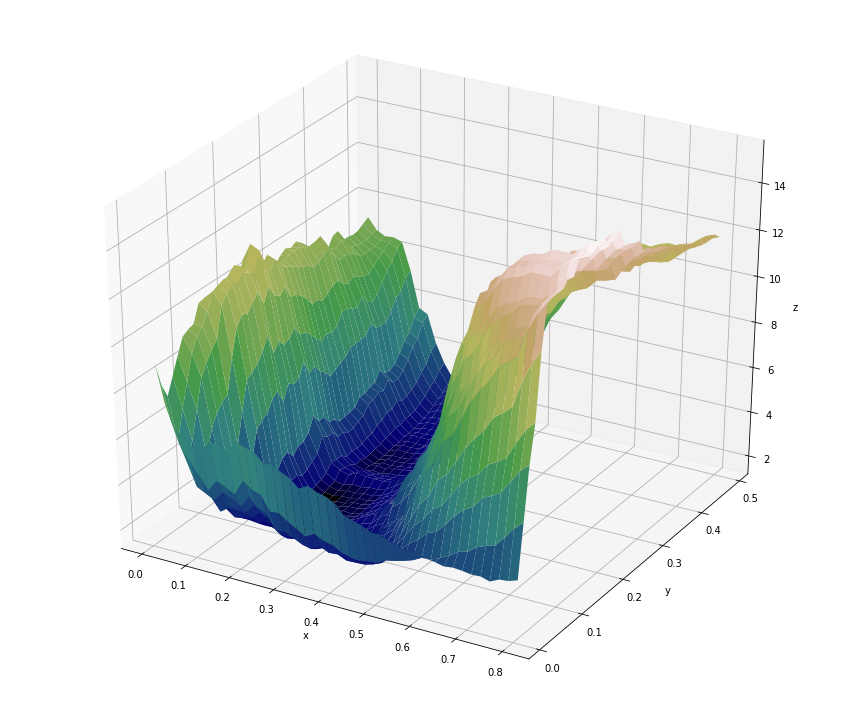

In [58]:
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 100, cmap=cm.CMRmap)
ax.plot_surface(X, Y, Z, cmap=cm.gist_earth)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.tight_layout()
# ax.view_init(45, -135)

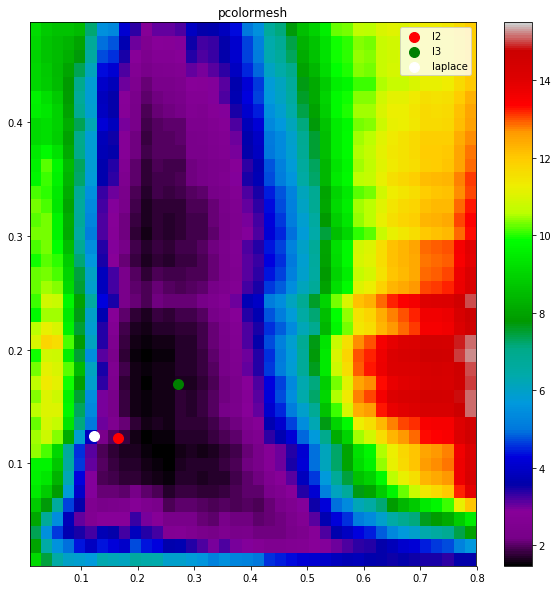

In [92]:
def plot_p(ax, init_points, i, c='r'):
    ax.scatter([s[0] for s, l in init_points][i], [s[1] for s, l in init_points][i], color=c, s=100);

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

cmesh = ax.pcolormesh(X, Y, Z, cmap='RdBu')

z_min, z_max = Z.min(), Z.max()

fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, Z, cmap=cm.spectral, vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([X.min(), X.max(), Y.min(), Y.max()])
fig.colorbar(c, ax=ax)

plot_p(ax, init_points, 0, 'r')
plot_p(ax, init_points, 1, 'g')
plot_p(ax, init_points, 2, 'w')

plt.legend(['l2', 'l3', 'laplace'])

plt.show()

In [93]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 6, 6

# cmesh = ax.pcolormesh(X, Y, Z, cmap='RdBu')

# z_min, z_max = Z.min(), Z.max()

# for i, c in enumerate(cmaps):
#     print("{}: {}".format(i, c))
#     fig, ax = plt.subplots()

#     c = ax.pcolormesh(X, Y, Z, cmap=c, vmin=z_min, vmax=z_max)
#     ax.set_title('pcolormesh')
#     # set the limits of the plot to the limits of the data
#     ax.axis([X.min(), X.max(), Y.min(), Y.max()])
#     fig.colorbar(c, ax=ax)

#     plt.show()

In [64]:
cmaps = [a for a in cm.__dir__() if type(getattr(cm, a)) == matplotlib.colors.ListedColormap or 
 type(getattr(cm, a)) == matplotlib.colors.LinearSegmentedColormap]
print(len(cmaps))

168


In [94]:
# for i, c in enumerate(cmaps):
#     print("{}: {}".format(i, c))
#     fig = plt.figure(figsize=(12, 10))
#     ax = plt.axes(projection='3d')
#     ax.contour3D(X, Y, Z, 100, cmap=c)
# #     ax.plot_surface(X, Y, Z, cmap=c)
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('z');
#     ax.view_init(45, -50)
#     plt.show()

(array([0.1660376 , 0.12212815]), 1.7927912473678589)
(array([0.27154553, 0.169586  ]), 1.678839087486267)
(array([0.12304047, 0.12450004]), 2.651759147644043)


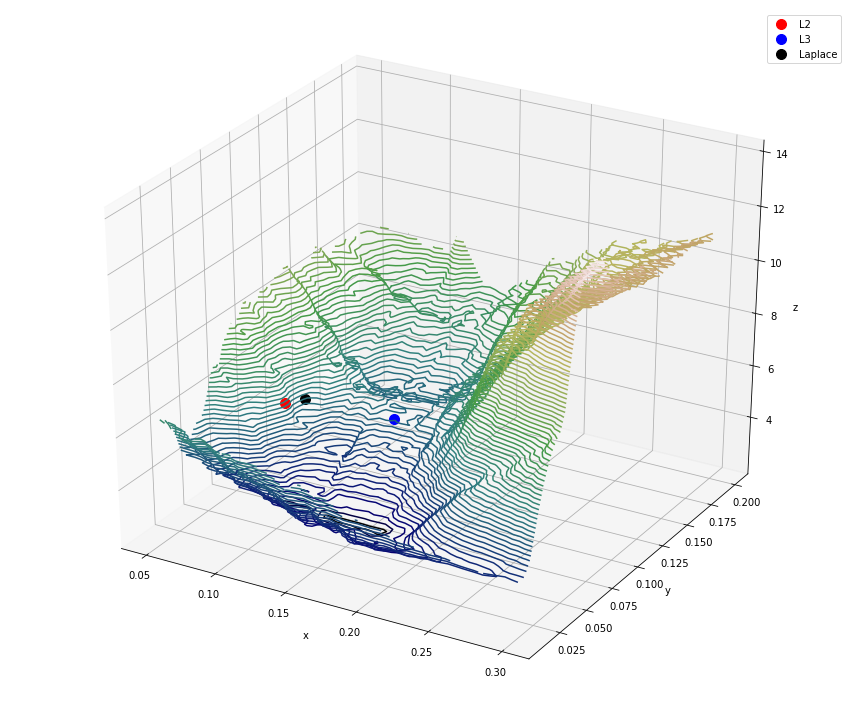

In [252]:
def plot_p(ax, init_points, i, c='r'):
    ax.scatter3D([s[0] for s, l in init_points][i],
             [s[1] for s, l in init_points][i],
             [l for s, l in init_points][i], color=c, s=100);

fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 100, cmap=cm.gist_earth)
# ax.contour3D(X, Y, Z, 100, cmap=cm.CMRmap)
# ax.plot_surface(X, Y, Z, cmap=cm.gist_earth)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

plot_p(ax, init_points, 0, 'r')
plot_p(ax, init_points, 1, 'b')
plot_p(ax, init_points, 2, 'k')

plt.tight_layout()
plt.legend(['L2', 'L3', 'Laplace'])
# ax.view_init(15, -90)
# ax.view_init(0)
plt.show()

In [159]:
# scales = np.array([q0.alpha.item(), q1.alpha.item()])
scales = np.array([X[0,3], Y[0,3]])
set_clipping(mq, scales, inf_model.device)

# evaluate with clipping
l2_loss = inf_model.evaluate_calibration()
print(l2_loss.item())

2.7737927436828613


In [167]:
Z.min()

2.551065444946289

In [44]:
X[2,:]

array([0.05      , 0.08888889, 0.12777778, 0.16666667, 0.20555556,
       0.24444444, 0.28333333, 0.32222222, 0.36111111, 0.4       ])

In [45]:
Y[:,2]

array([0.05      , 0.08888889, 0.12777778, 0.16666667, 0.20555556,
       0.24444444, 0.28333333, 0.32222222, 0.36111111, 0.4       ])

In [232]:
get_clipping(mq)

array([tensor([0.4000], device='cuda:0'),
       tensor([0.4000], device='cuda:0')], dtype=object)

In [128]:
import pickle

f = open('loss_mesh.data', 'wb')
pickle.dump({'x': X, 'y': Y, 'z': Z}, f)